https://towardsdatascience.com/machine-learning-part-17-boosting-algorithms-adaboost-in-python-d00faac6c464

In [1]:
# Imports related to data preprocessing

from os import path
from re import sub
from xml.etree.cElementTree import parse as xml_parse

import numpy as np
import pandas as pd
from scipy.stats import skew

In [2]:
# Imports for adaboost

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [3]:
# Retrive data from file

def data_retrive(filepath):
    #--parseing XML file --#
    xmlroot = xml_parse(filepath).getroot()
    for section in xmlroot.findall('Section'):
        if 'pdmp' in section.get('name').lower():
            opt_section = section
        else:
            fft_section = section


    opt_values = {
        node.tag: float(node.text)
        for node in opt_section.find('BestValues').getchildren()}


    snr = float(opt_values['Snr'])

    profileNode = opt_section.find('Profile')

    vmin = float(profileNode.get('min'))
    vmax = float(profileNode.get('max'))
    string = profileNode.text
    string = sub("[\t\s\n]", "", string)

    profile = np.asarray(bytearray.fromhex(string),dtype=float)
    profile = profile * (vmax - vmin) / 255. + vmin
    profile_skew = float(skew(profile))

    return(snr,profile_skew)

In [4]:
# Load data from files into numpy arrays 

snr_ar = np.empty(2392)
pfskew_ar = np.empty(2392)
ispulsar_ar = np.empty(2392, dtype='<U6')       #Used for classification. Yes or No. 1 or 0.

fileDir = path.dirname(path.realpath('__file__'))
for i in range(1196):
    file = '{0:04}'.format(i)
    filepath = path.join(fileDir, 'pulsars\pulsar_' + file + '.phcx')
    snr_ar[i],pfskew_ar[i]= data_retrive(filepath)
    ispulsar_ar[i] = 'Yes'

for i in range(1,1197):
    file = '{0:06}'.format(i)
    filepath = path.join(fileDir, 'Non_pulsars\cand_' + file + '.phcx')    #Different path for the non-pulsars
    snr_ar[1195 + i],pfskew_ar[1195 + i]= data_retrive(filepath)
    ispulsar_ar[1195 + i] = 'No'

C:\Users\abhi\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  from ipykernel import kernelapp as app


In [11]:
# From array to pandas dataframe

dataset = pd.DataFrame({'Snr':snr_ar,'Profile skew':pfskew_ar,'Is it a pulsar?':ispulsar_ar})
print(dataset.head())
X = dataset[['Snr','Profile skew']]
Y = dataset[['Is it a pulsar?']].astype('category')

         Snr  Profile skew Is it a pulsar?
0  51.500748      3.225603             Yes
1  30.875647      3.424006             Yes
2  11.802019      1.493347             Yes
3  79.968857      5.561036             Yes
4  11.877446      1.744047             Yes


In [6]:
# Spliting into training set and test set and one-hot encodeing. 1 = pulsar

encoder = LabelEncoder()
binary_encoded_y = pd.Series(encoder.fit_transform(Y))
train_X, test_X, train_y, test_y = train_test_split(X, binary_encoded_y, random_state=1)

C:\Users\abhi\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
# Define classifier with params

classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=250
)

# Train classifier
classifier.fit(train_X, train_y)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [8]:
# Evaluate on test set
predictions = classifier.predict(test_X)

result = confusion_matrix(test_y, predictions)

In [9]:
# Displaying results
print('Correctly identified pulsars =', result[0][0])
print('Correctly identified as Non-pulsars =', result[1][1])

print('\nWrongly identified as pulsars =', result[0][1])
print('Wrongly identified as Non-pulsars =', result[1][0])


print('\n\nRecall rate =',result[0][0]/(result[0][0]+result[1][0])*100,'%')
print('\n\nFalse positive rate =',result[0][1]/(result[1][1]+result[0][1])*100,'%')

Correctly identified pulsars = 292
Correctly identified as Non-pulsars = 291

Wrongly identified as pulsars = 8
Wrongly identified as Non-pulsars = 7


Recall rate = 97.65886287625418 %


False positive rate = 2.6755852842809364 %


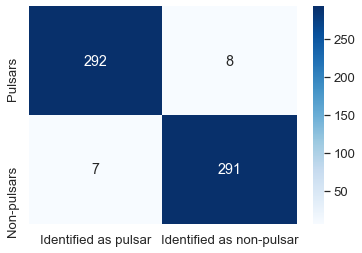

In [10]:
# plotting resulting confusion matrix

import seaborn as sn
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(result, ['Pulsars','Non-pulsars'], ['Identified as pulsar', 'Identified as non-pulsar'])
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.show()